In [59]:
import os, glob, shutil, sys, copy, time
from tqdm import tqdm
from pycromanager import Acquisition, Bridge, Dataset, multi_d_acquisition_events
from skimage import io, img_as_ubyte, color, transform, exposure
from skimage.filters import threshold_mean
from skimage.measure import shannon_entropy
import imagej
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
import scipy as sp

In [92]:
config = {
    "pixel-size-bf-10x" : 0.49,
    "pixel-size-bf-4x" : 1.174,
    "pixel-size-SHG" : 0.42,
    "camera-resolution" : (1392, 1040), # (width, height)
    "slide-size" : (40000.0, 20000.0), # (width, height) (70000, -20000)
    "slide-start" : (30000, -40000), # x, y
    "hard-limit-z" : (-3000.0, 22000.0),
    "hard-limit-x" : (25000.0, 75000.0),
    "hard-limit-y" : (-45000, -15000.0),
    "hard-limit-f" : (-4000, 20000),
}

In [87]:
def generate_grid(config, mag='20x', mod='bf', box=None, overlap=50):
    if box is not None:
        s_x = box[0]
        s_y = box[1]
        e_x = box[2]
        e_y = box[3]
    else:
        s_x = config["slide-start"][0]
        s_y = config["slide-start"][1]
        e_x = config["slide-start"][0] + config["slide-size"][0]
        e_y = config["slide-start"][1] + config["slide-size"][1]
    if mod == 'bf':
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        if mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
        field_w = config["camera-resolution"][0] * pixel_size
        field_h = config["camera-resolution"][1] * pixel_size 
    field_o = overlap * pixel_size
    grid_w = int(np.rint((e_x - s_x) / (field_w - field_o)))
    grid_h = int(np.rint((e_y - s_y) / (field_h - field_o)))
    xy_list = np.zeros((grid_h, grid_w, 2))
    for x in range(grid_w):
        for y in range(grid_h):
            x_pos = x * (field_w - field_o) + s_x
            y_pos = y * (field_h - field_o) + s_y
            # check hard limit
            xy_list[y, x] = [x_pos, y_pos] # x, y
    return xy_list, (grid_h, grid_w) # row, col

In [88]:
def whole_slide_scan(config, save_path, acq_name, position_list=None, grid=None, z_positions=None):
    if z_positions is not None:
        position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2)
        with Acquisition(save_path, acq_name) as acq:
            events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
            acq.acquire(events)
    else:
        with Acquisition(save_path, acq_name) as acq:
            events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
            acq.acquire(events)
#         with Acquisition(save_path, acq_name) as acq:
#             pos_count = 0
#             events = []
#             for idx_x in range(position_list.shape[1]):
#                 for idx_y in range(position_list.shape[0]):
#                     evt = {
#                         'axes' : {'position' : pos_count},
#                         'x' : position_list[idx_y, idx_x, 0],
#                         'y' : position_list[idx_y, idx_x, 1]
#                     }
#                     print(pos_count)
#                     pos_count = pos_count + 1
#                 events.append(evt)
#             acq.acquire(events)
#     if grid is not None:
#         with Acquisition(save_path, acq_name, tile_overlap=100) as acq:
#             for row in range(grid[0]):
#                 for col in range(grid[1]):
#                     acq.acquire({'row' : row, 'col' : col})

In [89]:
def stitching(config, ij, mod='bf', mag='4x', position_list=None):
    position_list_flat = position_list.reshape(-1, 2)
    stitch_folder = os.path.join('data/stitching/tiles', acq_name)
    os.makedirs(stitch_folder, exist_ok=True)
    out_folder = os.path.join('data/stitching/stitched', acq_name)
    os.makedirs(out_folder, exist_ok=True)
    if mod == 'bf':
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        if mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
    else:
        pixel_size = config["pixel-size-shg"] 
    with open(os.path.join(stitch_folder, 'TileConfiguration.txt'), 'w') as text_file:
        print('dim = {}'.format(2), file=text_file)
        for pos_row in range(position_list.shape[0]):
            for pos_col in range(position_list.shape[1]):
                x = int(position_list[pos_row, pos_col, 0] / pixel_size)
                y = int(position_list[pos_row, pos_col, 1] / pixel_size)
                print('{}_{}.tiff; ; ({}, {})'.format(pos_row, pos_col, x, y), file=text_file)
                img = dataset.read_image(position=pos_row*position_list.shape[1]+pos_col)
                io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
    sys.stdout.write('stitching, please wait...')
    temp_channel_folder = 'data/stitching/channel_temp'
    os.makedirs(temp_channel_folder, exist_ok=True)
    params = {'type': 'Positions from file', 'order': 'Defined by TileConfiguration', 
            'directory':stitch_folder, 'ayout_file': 'TileConfiguration.txt', 
            'fusion_method': 'Linear Blending', 'regression_threshold': '0.30', 
            'max/avg_displacement_threshold':'2.50', 'absolute_displacement_threshold': '3.50', 
            'compute_overlap':False, 'computation_parameters': 'Save computation time (but use more RAM)', 
            'image_output': 'Write to disk', 'output_directory': temp_channel_folder}
    plugin = "Grid/Collection stitching"
    ij.py.run_plugin(plugin, params)
    if mod == 'bf':
        list_channels = [f for f in os.listdir(temp_channel_folder)]
        if len(list_channels) == 1:
            c1 = io.imread(os.path.join(temp_channel_folder, list_channels[0]))
            io.imsave(os.path.join(out_folder, 'fused.tiff'), img_as_ubyte(c1))
        else:
            c1 = io.imread(os.path.join(temp_channel_folder, list_channels[0]))
            c2 = io.imread(os.path.join(temp_channel_folder, list_channels[1]))
            c3 = io.imread(os.path.join(temp_channel_folder, list_channels[2]))
            img_to_save = np.stack((c1, c2, c3)).transpose((1, 2, 0))
            io.imsave(os.path.join(out_folder, 'fused.tiff'), img_as_ubyte(img_to_save))
    shutil.rmtree(temp_channel_folder)

In [90]:
def bounding_image(config, image):
        img_g = color.rgb2gray(img)
        img_t = transform.rescale(img_g, 0.1, anti_aliasing=None, order=0)
        thresh = threshold_mean(img_t)
        img_d = 1 - (img_t > thresh)
        imgh = np.sum(img_d, axis = 1)
        imgw = np.sum(img_d, axis = 0)
        imgh_m = np.mean(imgh)
        imgw_m = np.mean(imgw)
        box_s_x = min(np.argwhere(imgw>imgw_m*0.2))[0] * 10
        box_s_y = min(np.argwhere(imgh>imgh_m*0.2))[0] * 10
        box_e_x = max(np.argwhere(imgw>imgw_m*0.2))[0] * 10
        box_e_y = max(np.argwhere(imgh>imgh_m*0.2))[0] * 10
        start = config["slide-start"]
        low_box_bounded = (config["slide-start"][0] + config["pixel-size-bf-4x"] * box_s_x,
                           config["slide-start"][1] + config["pixel-size-bf-4x"] * box_s_y,
                           config["slide-start"][0] + config["pixel-size-bf-4x"] * box_e_x,
                           config["slide-start"][1] + config["pixel-size-bf-4x"] * box_e_y,
                          )
        fig, ax = plt.subplots(1)
        ax.imshow(img_t, cmap='gray')
        rect = patches.Rectangle((int(box_s_x/10),int(box_s_y/10)), int((box_e_x-box_s_x)/10), int((box_e_y-box_s_y)/10), linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        return low_box_bounded # bounding box in real stage position

In [2]:
bridge = Bridge()
core = bridge.get_core()

In [35]:
def switch_objective(mag='4x'): # brightfield
    if mag == '4x':
        core.set_property('Turret:O:35', 'Label', 'Position-2')
        core.set_focus_device('ZStage:F:32')
        core.set_position(15000)
        time.sleep(1)
        core.set_focus_device('ZStage:Z:32')
        core.set_position(5200)
        time.sleep(1)
        core.set_property('LED-Dev1ao0', 'Voltage', 5.0000)
        # autofocus
    if mag == '20x':
        core.set_property('Turret:O:35', 'Label', 'Position-1')
        core.set_focus_device('ZStage:F:32')
        core.set_position(0)
        time.sleep(1)
        core.set_focus_device('ZStage:Z:32')
        core.set_position(-2000)
        time.sleep(1)
        core.set_property('LED-Dev1ao0', 'Voltage', 1.5)
        # autofocus      

In [36]:
switch_objective('4x')

In [96]:
save_path = 'data/acquisition'
acq_name = 'slide-color-test'

In [93]:
position_list, grid = generate_grid(config, mag='4x')
position_list.shape

(17, 25, 2)

In [94]:
position_list

array([[[ 30000.   , -40000.   ],
        [ 31575.508, -40000.   ],
        [ 33151.016, -40000.   ],
        [ 34726.524, -40000.   ],
        [ 36302.032, -40000.   ],
        [ 37877.54 , -40000.   ],
        [ 39453.048, -40000.   ],
        [ 41028.556, -40000.   ],
        [ 42604.064, -40000.   ],
        [ 44179.572, -40000.   ],
        [ 45755.08 , -40000.   ],
        [ 47330.588, -40000.   ],
        [ 48906.096, -40000.   ],
        [ 50481.604, -40000.   ],
        [ 52057.112, -40000.   ],
        [ 53632.62 , -40000.   ],
        [ 55208.128, -40000.   ],
        [ 56783.636, -40000.   ],
        [ 58359.144, -40000.   ],
        [ 59934.652, -40000.   ],
        [ 61510.16 , -40000.   ],
        [ 63085.668, -40000.   ],
        [ 64661.176, -40000.   ],
        [ 66236.684, -40000.   ],
        [ 67812.192, -40000.   ]],

       [[ 30000.   , -38837.74 ],
        [ 31575.508, -38837.74 ],
        [ 33151.016, -38837.74 ],
        [ 34726.524, -38837.74 ],
        [ 36

In [97]:
whole_slide_scan(config, save_path, acq_name, position_list=position_list, grid=None)

In [99]:
data_path = glob.glob(save_path+'/'+acq_name+'*')[-1]
dataset = Dataset(data_path)
dataset.axes

Opening file 1 of 1

KeyError: 'GridPixelOverlapX'

In [17]:
ij = imagej.init('fiji/fiji/Fiji.app/')

In [18]:
stitching(config, ij, position_list=position_list)

<ipython-input-5-7bfd0ccdc6c7>:22: UserWarning: data/stitching/tiles\slide-color-test/0_0.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
<ipython-input-5-7bfd0ccdc6c7>:22: UserWarning: data/stitching/tiles\slide-color-test/0_1.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
<ipython-input-5-7bfd0ccdc6c7>:22: UserWarning: data/stitching/tiles\slide-color-test/0_2.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
<ipython-input-5-7bfd0ccdc6c7>:22: UserWarning: data/stitching/tiles\slide-color-test/0_3.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(img))
<ipython-input-5-7bfd0ccdc6c7>:22: UserWarning: data/stitching/tiles\slide-color-test/1_0.tiff is a low contrast image
  io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, pos_col),

stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 512x512px, channels=3, timepoints=1 (659 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 512x512px, channels=3, timepoints=1 (43 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-sca

In [26]:
Image.MAX_IMAGE_PIXELS = None        
img = io.imread('example/BIC14011b.jpg')

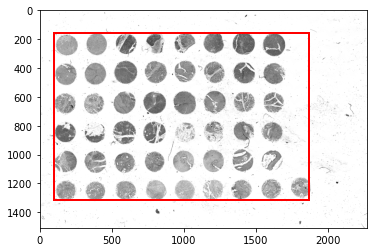

(2250.0, 3555.0, 42007.5, 29632.5)

In [67]:
bounding_box_4x = bounding_image(config, img)

In [111]:
position_list_20x, grid_20x = generate_grid(config, mag='20x')
position_list_20x.shape

(17, 22, 2)

In [83]:
# optimal 5085
core.set_position(4969)

In [84]:
core.get_position()

4969

In [85]:
autofocus(core, search_range=90)

4929
17.64436457496112
4939
17.65342005021535
4949
17.661655348030425
4959
17.668416834855833
4969
17.674633440854986
4979
17.67761608605648
4989
17.67937351747418
4999
17.67871046983665
72


4992.797468354431

In [76]:
def autofocus(core, method='entropy', rgb=True, search_range=45, crop_ratio=1.0):
    current_z = core.get_position()
    interval_z = int(search_range/9)
    scores = []
    positions = []
    count = 0
    for step in range(-4, 4):
        position_z = step * interval_z + current_z
        if position_z < -3000.0 or position_z > 22000.0:
            break
        core.set_position(position_z)
        if count == 0:
            time.sleep(1.0)
        else:
            time.sleep(0.25)
        count = count + 1
        core.snap_image()
        tagged_image = core.get_tagged_image()
        if rgb == True:
            pixels = np.reshape(
                tagged_image.pix,
                newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
                )
        else:
            pixels = np.reshape(
                tagged_image.pix,
                newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
                )
#         print(pixels.shape)
#         plt.figure(figsize=(8, 6))
#         imgplot = plt.imshow(exposure.rescale_intensity(pixels[:, :, 0:3], out_range=(0, 1)))
#         plt.axis("off")
#         plt.show()
        img_gray = color.rgb2gray(color.rgba2rgb(pixels))
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        print(position_z)
        print(score)
        scores.append(score)
        positions.append(position_z)
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions)
#     scores_array = scores_array/np.sum(scores_array)
#     mean, _ = norm.fit(scores_array)
    
    new_length = len(positions) * 10
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind='cubic')(new_x)
#     print(new_y)
    idx = np.argmax(new_y)
    print(idx)
    focus_z = new_x[idx]
#     print(focus_z)
    # check hard limit
    return focus_z

def focus_dive(core, position_list, search_range=45, resample_grid_size=None):
    xy_positions=position_list.reshape(-1, 2)
    z_positions=np.ones(xy_positions.shape[0]) * core.get_position()
    for i in tqdm(range(xy_positions.shape[0])):
        # check hard limit
        position = xy_positions[i]
        core.set_xy_position(position[0], position[1])
        time.sleep(0.25)
        pos_z = autofocus(core, search_range=search_range)
        core.set_position(pos_z)
        time.sleep(0.25)
        z_positions[i] = pos_z
    position_list_z = z_positions.reshape(position_list.shape[0], position_list.shape[1])
    if resample_grid_size is not None:
        position_list_z = transform.resize(position_list_z, output_shape=resample_grid_size, order=3)
    return position_list_z

In [140]:
position_list.shape
position_list_20x.shape

(17, 22, 2)

In [141]:
position_list_z = focus_dive(core, position_list, search_range=18, resample_grid_size=(position_list_20x.shape[0], position_list_20x.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.13s/it]


In [145]:
position_list_z.shape

(17, 22)

In [152]:
position_list_20x.shape

(17, 22, 2)

In [153]:
whole_slide_scan(config, save_path, acq_name, position_list=position_list_20x, z_positions=position_list_z)